In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import pickle
import seaborn as sns

%matplotlib inline

In [2]:
# """
# def get_data(week_nums):
#     url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
#     dfs = []
#     for week_num in week_nums:
#         file_url = url.format(week_num)
#         dfs.append(pd.read_csv(file_url))
#     return pd.concat(dfs)
        
# week_nums = [160903, 160910, 160917]
# turnstiles_df = get_data(week_nums)
# """"

In [3]:
path = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_190921.txt'
col_names= ['CA','UNIT','SCP','STATION','LINENAME','DIVISION','DATE','TIME','DESC','ENTRIES','EXITS']
df = pd.read_csv(path, sep=",", header=0, names = col_names, parse_dates=[['DATE', 'TIME']])

In [4]:
df.head()

,DATE_TIME,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,ENTRIES,EXITS
0,2019-09-14 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7198818,2438323
1,2019-09-14 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7198834,2438325
2,2019-09-14 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7198847,2438354
3,2019-09-14 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7198929,2438428
4,2019-09-14 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7199125,2438483


In [5]:
df.columns

Index(['DATE_TIME', 'CA', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [6]:
df.groupby(["CA", "UNIT", "SCP", "STATION", "DATE_TIME"]).ENTRIES.count().reset_index().sort_values("ENTRIES", ascending=False).head(5)

,CA,UNIT,SCP,STATION,DATE_TIME,ENTRIES
127639,R101,R001,02-00-04,SOUTH FERRY,2019-09-17 05:00:00,2
127765,R101,R001,02-00-07,SOUTH FERRY,2019-09-17 05:00:00,2
136609,R138,R293,00-03-02,34 ST-PENN STA,2019-09-18 14:00:00,1
136611,R138,R293,00-03-02,34 ST-PENN STA,2019-09-18 22:00:00,1
136612,R138,R293,00-03-02,34 ST-PENN STA,2019-09-19 02:00:00,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204928 entries, 0 to 204927
Data columns (total 10 columns):
DATE_TIME    204928 non-null datetime64[ns]
CA           204928 non-null object
UNIT         204928 non-null object
SCP          204928 non-null object
STATION      204928 non-null object
LINENAME     204928 non-null object
DIVISION     204928 non-null object
DESC         204928 non-null object
ENTRIES      204928 non-null int64
EXITS        204928 non-null int64
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 15.6+ MB


In [8]:
mask = ((df["CA"] == "R101") & 
(df["UNIT"] == "R001") & 
(df["SCP"] == "02-00-04") &
(df["STATION"] == "SOUTH FERRY") & 
(df['DATE_TIME'] == '2019-09-17 05:00:00'))
# (df["DATE_TIME"].dt.date == datetime.datetime(2019, 9, 17).date()))

In [9]:
df[mask].head()

,DATE_TIME,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,ENTRIES,EXITS
127639,2019-09-17 05:00:00,R101,R001,02-00-04,SOUTH FERRY,1RW,IRT,REGULAR,3062453,2464020
127640,2019-09-17 05:00:00,R101,R001,02-00-04,SOUTH FERRY,1RW,IRT,RECOVR AUD,3062452,2464020


In [10]:
df = df[df.DESC == 'REGULAR']

In [11]:
df.groupby(["CA", "UNIT", "SCP", "STATION", "DATE_TIME"]).ENTRIES.count().reset_index().sort_values("ENTRIES", ascending=False).head(5)

,CA,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2019-09-14 00:00:00,1
136149,R138,R293,00-03-02,34 ST-PENN STA,2019-09-18 02:00:00,1
136151,R138,R293,00-03-02,34 ST-PENN STA,2019-09-18 10:00:00,1
136152,R138,R293,00-03-02,34 ST-PENN STA,2019-09-18 14:00:00,1
136153,R138,R293,00-03-02,34 ST-PENN STA,2019-09-18 18:00:00,1


In [12]:
daily_df = df.groupby(["CA", "UNIT", "SCP", "STATION", "DATE_TIME"])["ENTRIES","EXITS"].first().reset_index()

In [13]:
daily_df.head()

,CA,UNIT,SCP,STATION,DATE_TIME,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,2019-09-14 00:00:00,7198818,2438323
1,A002,R051,02-00-00,59 ST,2019-09-14 04:00:00,7198834,2438325
2,A002,R051,02-00-00,59 ST,2019-09-14 08:00:00,7198847,2438354
3,A002,R051,02-00-00,59 ST,2019-09-14 12:00:00,7198929,2438428
4,A002,R051,02-00-00,59 ST,2019-09-14 16:00:00,7199125,2438483


In [14]:
daily_df['ENTRIES'] = daily_df.groupby(["CA", "UNIT", "SCP", "STATION"]).ENTRIES.transform(
    lambda x: np.where((x<0)|(x>20000),x.mask((x<0)|(x>20000)).mean(),x))
daily_df['EXITS'] = daily_df.groupby(["CA", "UNIT", "SCP", "STATION"]).EXITS.transform(lambda x: np.where((x<0)|(x>20000),x.mask((x<0)|(x>20000)).mean(),x))

In [15]:
daily_df[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = (daily_df.groupby(["CA", "UNIT", "SCP", "STATION"])["DATE_TIME", "ENTRIES", "EXITS"].transform(lambda grp: grp.shift(1)))

In [16]:
daily_df.head()

,CA,UNIT,SCP,STATION,DATE_TIME,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS
0,A002,R051,02-00-00,59 ST,2019-09-14 00:00:00,NaN,NaN,NaT,NaN,NaN
1,A002,R051,02-00-00,59 ST,2019-09-14 04:00:00,NaN,NaN,2019-09-14 00:00:00,NaN,NaN
2,A002,R051,02-00-00,59 ST,2019-09-14 08:00:00,NaN,NaN,2019-09-14 04:00:00,NaN,NaN
3,A002,R051,02-00-00,59 ST,2019-09-14 12:00:00,NaN,NaN,2019-09-14 08:00:00,NaN,NaN
4,A002,R051,02-00-00,59 ST,2019-09-14 16:00:00,NaN,NaN,2019-09-14 12:00:00,NaN,NaN


In [17]:
daily_df.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [18]:
daily_df[daily_df["ENTRIES"] < daily_df["PREV_ENTRIES"]].head(20)


,CA,UNIT,SCP,STATION,DATE_TIME,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS
18414,B028,R136,01-00-01,SHEEPSHEAD BAY,2019-09-15 13:00:00,24.000000,21.0,2019-09-15 09:00:00,3757.454545,1302.969697
25483,D005,R398,00-06-00,NEW UTRECHT AV,2019-09-17 13:00:00,138.000000,41.0,2019-09-17 09:00:00,15695.000000,5370.000000
38612,J017,R432,00-00-02,CHAUNCEY ST,2019-09-17 21:00:00,98.000000,200.0,2019-09-17 13:00:00,1189.750000,1304.125000
40760,JFK01,R535,00-00-03,HOWARD BCH JFK,2019-09-19 17:00:00,10.000000,133.0,2019-09-19 13:00:00,12054.000000,633.125000
41054,JFK03,R536,00-00-02,JFK JAMAICA CT1,2019-09-19 17:00:00,15144.882353,2969.0,2019-09-19 13:00:00,19870.000000,2946.000000
41316,JFK03,R536,00-03-03,JFK JAMAICA CT1,2019-09-20 17:00:00,17463.057143,NaN,2019-09-20 13:00:00,19693.000000,NaN
42521,K026,R100,00-00-04,METROPOLITAN AV,2019-09-19 12:00:00,85.000000,62.0,2019-09-18 08:00:00,851.777778,952.333333
46158,N025,R102,01-00-00,125 ST,2019-09-18 20:00:00,126.000000,236.0,2019-09-18 12:00:00,1104.923077,1274.846154
56123,N078,R175,01-03-00,14 ST,2019-09-15 01:00:00,19591.666667,19998.0,2019-09-14 21:00:00,19974.000000,19906.000000
56179,N078,R175,01-03-01,14 ST,2019-09-17 21:00:00,17988.350000,16777.0,2019-09-17 17:00:00,19647.000000,16575.000000


In [19]:
new_mask = ((df["CA"] == "A011") & 
(df["UNIT"] == "R080") & 
(df["SCP"] == "01-03-00") & 
(df["STATION"] == "57 ST-7 AV") &
(df["DATE_TIME"] == '2019-09-14 04:00:00'))

In [20]:
df[new_mask].head()

,DATE_TIME,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,ENTRIES,EXITS
1601,2019-09-14 04:00:00,A011,R080,01-03-00,57 ST-7 AV,NQRW,BMT,REGULAR,885813434,490308745


In [21]:
(daily_df[daily_df["ENTRIES"] < daily_df["PREV_ENTRIES"]]
    .groupby(["CA", "UNIT", "SCP", "STATION"])
    .size())

CA     UNIT  SCP       STATION        
B028   R136  01-00-01  SHEEPSHEAD BAY     1
D005   R398  00-06-00  NEW UTRECHT AV     1
J017   R432  00-00-02  CHAUNCEY ST        1
JFK01  R535  00-00-03  HOWARD BCH JFK     1
JFK03  R536  00-00-02  JFK JAMAICA CT1    1
             00-03-03  JFK JAMAICA CT1    1
K026   R100  00-00-04  METROPOLITAN AV    1
N025   R102  01-00-00  125 ST             1
N078   R175  01-03-00  14 ST              1
             01-03-01  14 ST              1
N092   R029  03-00-05  CHAMBERS ST        1
N119   R199  00-00-01  KINGSTON-THROOP    1
N316   R267  00-00-01  46 ST              1
N339A  R114  00-00-00  PARSONS BLVD       1
PTH03  R552  00-01-08  JOURNAL SQUARE     2
PTH12  R542  00-00-02  TWENTY THIRD ST    1
PTH13  R541  00-04-02  THIRTY ST          2
             00-04-04  THIRTY ST          1
PTH16  R550  01-00-08  LACKAWANNA         1
             01-01-01  LACKAWANNA         1
             01-01-08  LACKAWANNA         1
             01-02-00  LACKAWANNA    

In [22]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"] + row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        return 0
    return counter

In [23]:
daily_df["4H_SUM"] = daily_df.apply(get_daily_counts, axis=1, max_counter=1000000) 

In [24]:
daily_df.head()

,CA,UNIT,SCP,STATION,DATE_TIME,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS,4H_SUM
1,A002,R051,02-00-00,59 ST,2019-09-14 04:00:00,NaN,NaN,2019-09-14 00:00:00,NaN,NaN,NaN
2,A002,R051,02-00-00,59 ST,2019-09-14 08:00:00,NaN,NaN,2019-09-14 04:00:00,NaN,NaN,NaN
3,A002,R051,02-00-00,59 ST,2019-09-14 12:00:00,NaN,NaN,2019-09-14 08:00:00,NaN,NaN,NaN
4,A002,R051,02-00-00,59 ST,2019-09-14 16:00:00,NaN,NaN,2019-09-14 12:00:00,NaN,NaN,NaN
5,A002,R051,02-00-00,59 ST,2019-09-14 20:00:00,NaN,NaN,2019-09-14 16:00:00,NaN,NaN,NaN


In [25]:
top_20_stations_with_sum = daily_df.groupby(['STATION'])['4H_SUM'].sum().sort_values(ascending = False).head(20)
print(top_20_stations_with_sum)

STATION
THIRTY ST          79710.292848
72 ST              66339.730519
JOURNAL SQUARE     50523.000000
BOROUGH HALL       43065.804113
LACKAWANNA         39220.254444
NEW UTRECHT AV     27506.000000
GRD CNTRL-42 ST    26826.531250
CITY / BUS         26066.000000
157 ST             24541.235294
FULTON ST          22730.666667
46 ST              22204.000000
14 ST              21362.996847
TWENTY THIRD ST    20796.615385
NEWARK BM BW       20542.899725
JUNCTION BLVD      19954.416667
PARSONS BLVD       19320.928571
B'WAY-LAFAYETTE    18928.000000
PARKCHESTER        18791.800000
5 AVE              18353.000000
KINGSTON-THROOP    18243.000000
Name: 4H_SUM, dtype: float64


In [26]:
['GRD CNTRL-42 ST',
'34 ST-PENN STA',
'METROPOLITAN AV',
'34 ST-HERALD SQ',
'23 ST',
'BOWLING GREEN',
'14 ST-UNION SQ',
'42 ST-PORT AUTH',
'TIMES SQ-42 ST',
'FULTON ST',
'86 ST',
'RIT-MANHATTAN',
'125 ST',
'CANAL ST',
'JUNCTION BLVD',
'59 ST COLUMBUS',
'THIRTY THIRD ST',
'14 ST',
'96 ST',
'GROVE STREET']

['GRD CNTRL-42 ST',
 '34 ST-PENN STA',
 'METROPOLITAN AV',
 '34 ST-HERALD SQ',
 '23 ST',
 'BOWLING GREEN',
 '14 ST-UNION SQ',
 '42 ST-PORT AUTH',
 'TIMES SQ-42 ST',
 'FULTON ST',
 '86 ST',
 'RIT-MANHATTAN',
 '125 ST',
 'CANAL ST',
 'JUNCTION BLVD',
 '59 ST COLUMBUS',
 'THIRTY THIRD ST',
 '14 ST',
 '96 ST',
 'GROVE STREET']

In [27]:
top_20 = list(top_20_stations_with_sum.index[2:])

In [28]:
top_20

['JOURNAL SQUARE',
 'BOROUGH HALL',
 'LACKAWANNA',
 'NEW UTRECHT AV',
 'GRD CNTRL-42 ST',
 'CITY / BUS',
 '157 ST',
 'FULTON ST',
 '46 ST',
 '14 ST',
 'TWENTY THIRD ST',
 'NEWARK BM BW',
 'JUNCTION BLVD',
 'PARSONS BLVD',
 "B'WAY-LAFAYETTE",
 'PARKCHESTER',
 '5 AVE',
 'KINGSTON-THROOP']

In [29]:
df_top_20 = daily_df[daily_df['STATION'].isin(top_20)]

In [30]:
df_top_20.head(5)

,CA,UNIT,SCP,STATION,DATE_TIME,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS,4H_SUM
12116,A077,R028,03-00-00,FULTON ST,2019-09-14 11:00:00,NaN,NaN,2019-09-14 03:00:00,NaN,NaN,NaN
12117,A077,R028,03-00-00,FULTON ST,2019-09-14 15:00:00,NaN,NaN,2019-09-14 11:00:00,NaN,NaN,NaN
12118,A077,R028,03-00-00,FULTON ST,2019-09-14 19:00:00,NaN,NaN,2019-09-14 15:00:00,NaN,NaN,NaN
12119,A077,R028,03-00-00,FULTON ST,2019-09-14 23:00:00,NaN,NaN,2019-09-14 19:00:00,NaN,NaN,NaN
12120,A077,R028,03-00-00,FULTON ST,2019-09-15 03:00:00,NaN,NaN,2019-09-14 23:00:00,NaN,NaN,NaN


In [31]:
df_top_20 = df_top_20.set_index('DATE_TIME')
df_top_20.drop(['PREV_DATE'], axis=1, inplace=True)
df_top_20.head()

,CA,UNIT,SCP,STATION,ENTRIES,EXITS,PREV_ENTRIES,PREV_EXITS,4H_SUM
DATE_TIME,,,,,,,,,
2019-09-14 11:00:00,A077,R028,03-00-00,FULTON ST,NaN,NaN,NaN,NaN,NaN
2019-09-14 15:00:00,A077,R028,03-00-00,FULTON ST,NaN,NaN,NaN,NaN,NaN
2019-09-14 19:00:00,A077,R028,03-00-00,FULTON ST,NaN,NaN,NaN,NaN,NaN
2019-09-14 23:00:00,A077,R028,03-00-00,FULTON ST,NaN,NaN,NaN,NaN,NaN
2019-09-15 03:00:00,A077,R028,03-00-00,FULTON ST,NaN,NaN,NaN,NaN,NaN


In [32]:
fourH_DailyEntries_top_20 = df_top_20.groupby(['STATION'])['4H_SUM'].resample('4H').sum()

In [33]:
fourH_DailyEntries_top_20

STATION          DATE_TIME          
14 ST            2019-09-14 04:00:00       0.000000
                 2019-09-14 08:00:00       0.000000
                 2019-09-14 12:00:00       0.000000
                 2019-09-14 16:00:00    1131.000000
                 2019-09-14 20:00:00     965.000000
                 2019-09-15 00:00:00     462.333333
                 2019-09-15 04:00:00     285.500000
                 2019-09-15 08:00:00      33.000000
                 2019-09-15 12:00:00     177.000000
                 2019-09-15 16:00:00     404.000000
                 2019-09-15 20:00:00     315.000000
                 2019-09-16 00:00:00     103.000000
                 2019-09-16 04:00:00      10.000000
                 2019-09-16 08:00:00     261.000000
                 2019-09-16 12:00:00     464.000000
                 2019-09-16 16:00:00     609.000000
                 2019-09-16 20:00:00     801.000000
                 2019-09-17 00:00:00     133.000000
                 2019-09-17

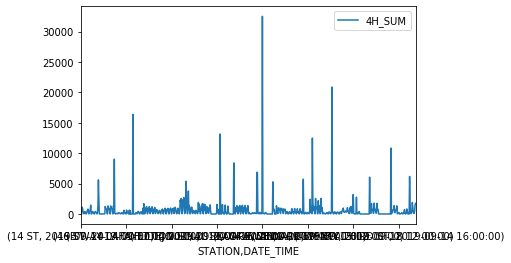

In [34]:
fourH_DailyEntries_top_20.plot(kind='line', legend=True)

In [35]:
# cols_plot = ['Consumption', 'Solar', 'Wind']
# axes = opsd_daily[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
# for ax in axes:
#     ax.set_ylabel('Daily Totals (GWh)')

In [36]:
daily_df = daily_df.set_index('DATE_TIME')
daily_df.drop(['PREV_DATE'], axis=1, inplace=True)
daily_df.head()

,CA,UNIT,SCP,STATION,ENTRIES,EXITS,PREV_ENTRIES,PREV_EXITS,4H_SUM
DATE_TIME,,,,,,,,,
2019-09-14 04:00:00,A002,R051,02-00-00,59 ST,NaN,NaN,NaN,NaN,NaN
2019-09-14 08:00:00,A002,R051,02-00-00,59 ST,NaN,NaN,NaN,NaN,NaN
2019-09-14 12:00:00,A002,R051,02-00-00,59 ST,NaN,NaN,NaN,NaN,NaN
2019-09-14 16:00:00,A002,R051,02-00-00,59 ST,NaN,NaN,NaN,NaN,NaN
2019-09-14 20:00:00,A002,R051,02-00-00,59 ST,NaN,NaN,NaN,NaN,NaN


In [37]:
# df.plot(figsize=(15,4))
# df.plot(subplots=True, figsize=(15,6))
# df.plot(y=[["CA", "UNIT", "SCP", "STATION"]], figsize=(15,4))
# df.plot(x=["STATION"], y=[["CA", "UNIT", "SCP"]], style='.')

sns.distplot(df.ENTRIES())
sns.plt.show()

TypeError: 'Series' object is not callable